In [2]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math
import torch

import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append('../')
from src.data_generator import MRIDataset
from src.utils import get_glioma_indices, plot_tumour

In [3]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

In [4]:
t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))

clicks_dataset = MRIDataset(
    t1_list[2:4], t2_list[2:4], seg_list[2:4],
    (40, 256, 256),
    clicks = {
        'use': True,
        'gen_fg': False,
        'gen_bg': False,
        'gen_border': True,
        'num': 3,
        'dst': 10
    }
)

In [5]:
t1_list[2:4]

['../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz',
 '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz']

In [6]:
img, label = clicks_dataset[0]
# click_label = click_label[1].unsqueeze(0)

Tumour indices:  11 27


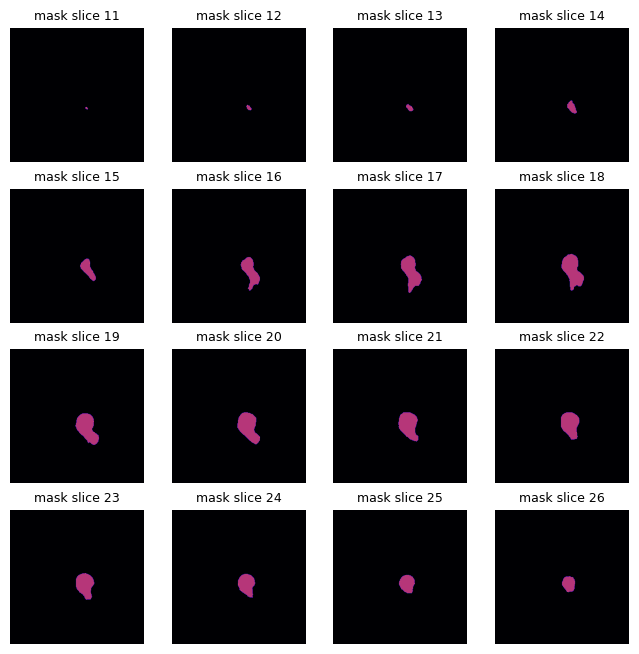

In [7]:
plot_tumour(label[0].unsqueeze(0) + label[1].unsqueeze(0))

In [8]:
click_coords = torch.nonzero(label[1])
click_coords[:10]

tensor([[ 11, 151, 146],
        [ 12, 147, 144],
        [ 12, 156, 150],
        [ 13, 150, 140],
        [ 13, 151, 150],
        [ 14, 142, 141],
        [ 14, 152, 139],
        [ 14, 160, 155],
        [ 15, 141, 136],
        [ 15, 141, 152]])

In [9]:
click_coords[0]

tensor([ 11, 151, 146])

torch.Size([40, 40])


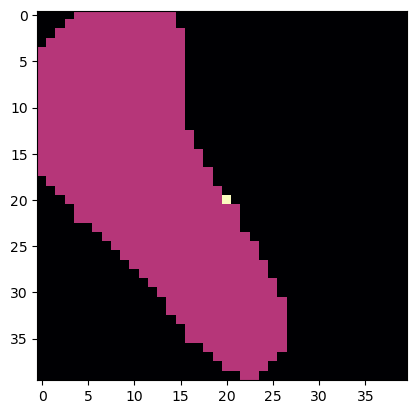

In [10]:
click_idx = 10
cut_size = 20
coords = click_coords[click_idx]

# print((coords[1]-cut_size, coords[1]+cut_size))
# print((coords[2]-cut_size, coords[2]+cut_size))

click = torch.zeros_like(label[0, coords[0]])
click[coords[1], coords[2]] = 1

a = label[0, coords[0]] + click
cut = a[
    coords[1]-cut_size:coords[1]+cut_size,
    coords[2]-cut_size:coords[2]+cut_size
]
print(cut.shape)
plt.imshow(cut, cmap='magma')

## Cuts

In [11]:
def cut_volume(label, cut_size=20, num=12):
    click_coords = torch.nonzero(label[1])
    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        click = torch.zeros_like(label[0][coords[0]])
        click[coords[1], coords[2]] = 1

        a = label[0][coords[0]] + click
        cut = a[
            coords[1]-cut_size:coords[1]+cut_size,
            coords[2]-cut_size:coords[2]+cut_size
        ]
        cuts.append(cut)
    
    return cuts, click_coords

In [78]:
def plot_cuts(cuts):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        axs[j].imshow(cut, cmap='magma')
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

In [61]:
label.shape

torch.Size([2, 40, 256, 256])

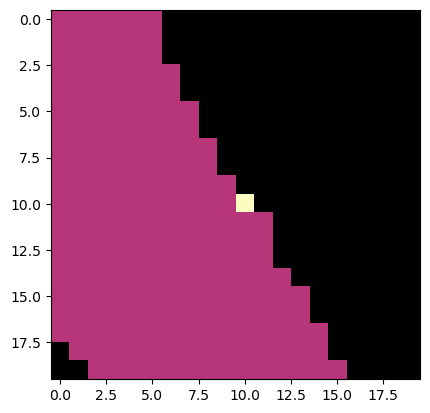

In [13]:
cuts, clicks = cut_volume(label, cut_size=10, num=24)
plt.imshow(cuts[10], cmap='magma')

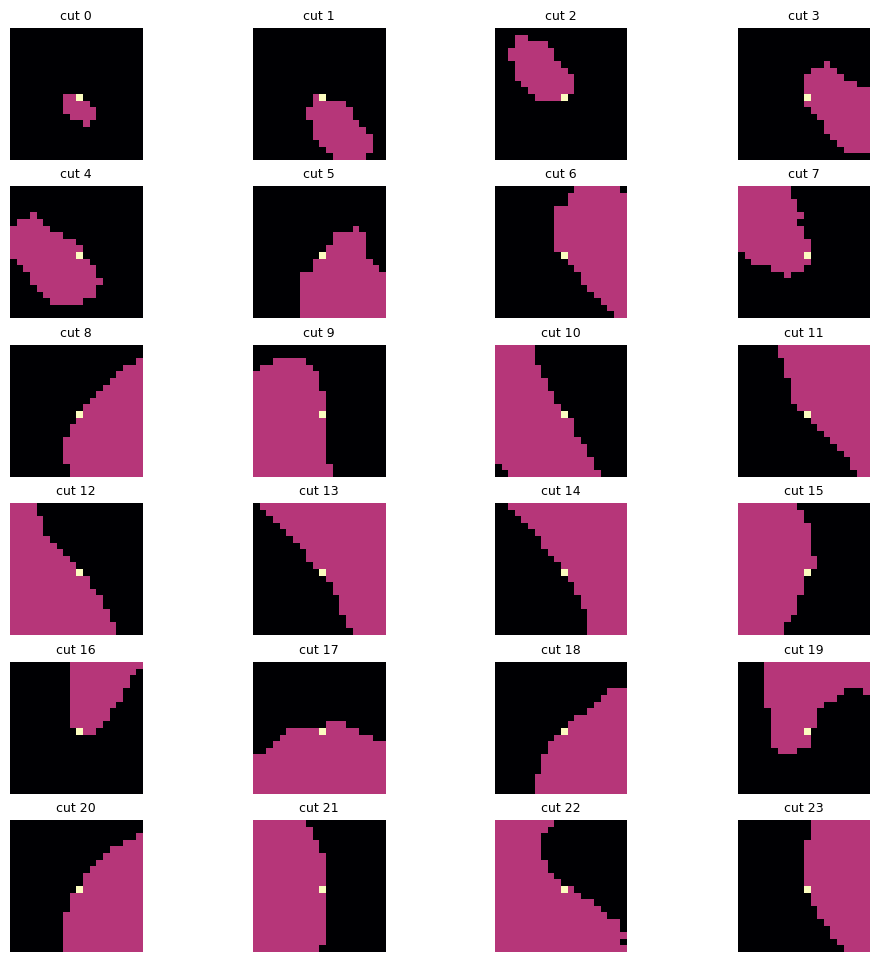

In [14]:
plot_cuts(cuts)

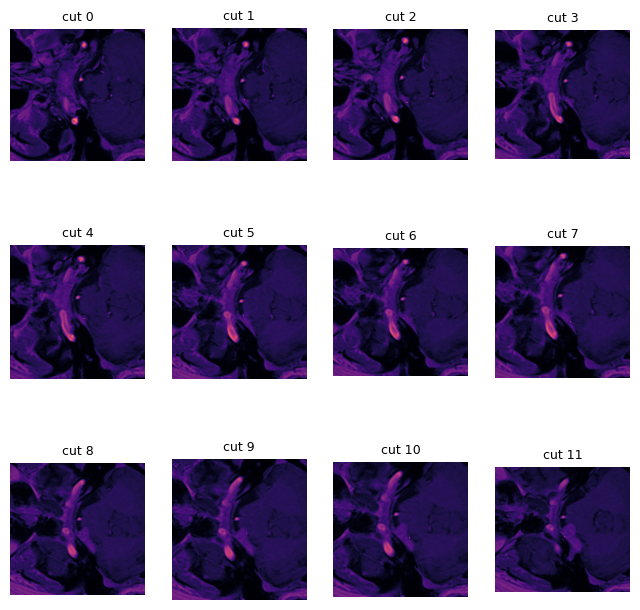

In [15]:
img[1] = label[1]
plot_cuts(cut_volume(img, cut_size=128, num=12)[0])

In [16]:
cuts, clicks = cut_volume(label, cut_size=10, num=24)
clicks[10]

tensor([ 15, 156, 157])

In [17]:
fig = px.imshow(cuts[10])
fig.show()

In [18]:
from copy import deepcopy

In [42]:
def fake_errors(cuts):
    cuts, _ = cut_volume(label, cut_size=10, num=24)

    faked_cuts = deepcopy(cuts)
    for cut in faked_cuts:
        width = cut.shape[0]
        heigth = cut.shape[1]

        for x in range(width):
            for y in range(heigth):
                if cut[x, y] == 1:
                    dst = np.linalg.norm([width//2 - x, heigth//2 - y]) 
                    p = (dst/(heigth//2)) ** 2
                    # print(p, dst)
                    if p < np.random.uniform(low=0.0, high=1.0):
                        cut[x, y] = 0

    return faked_cuts

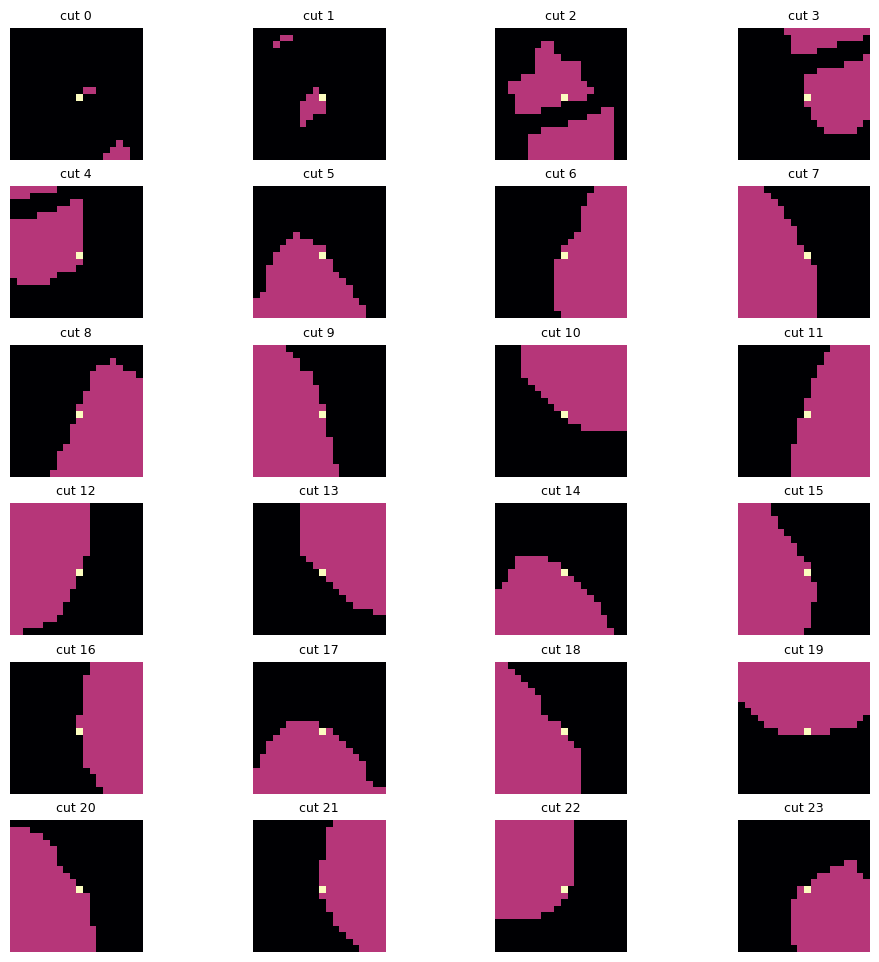

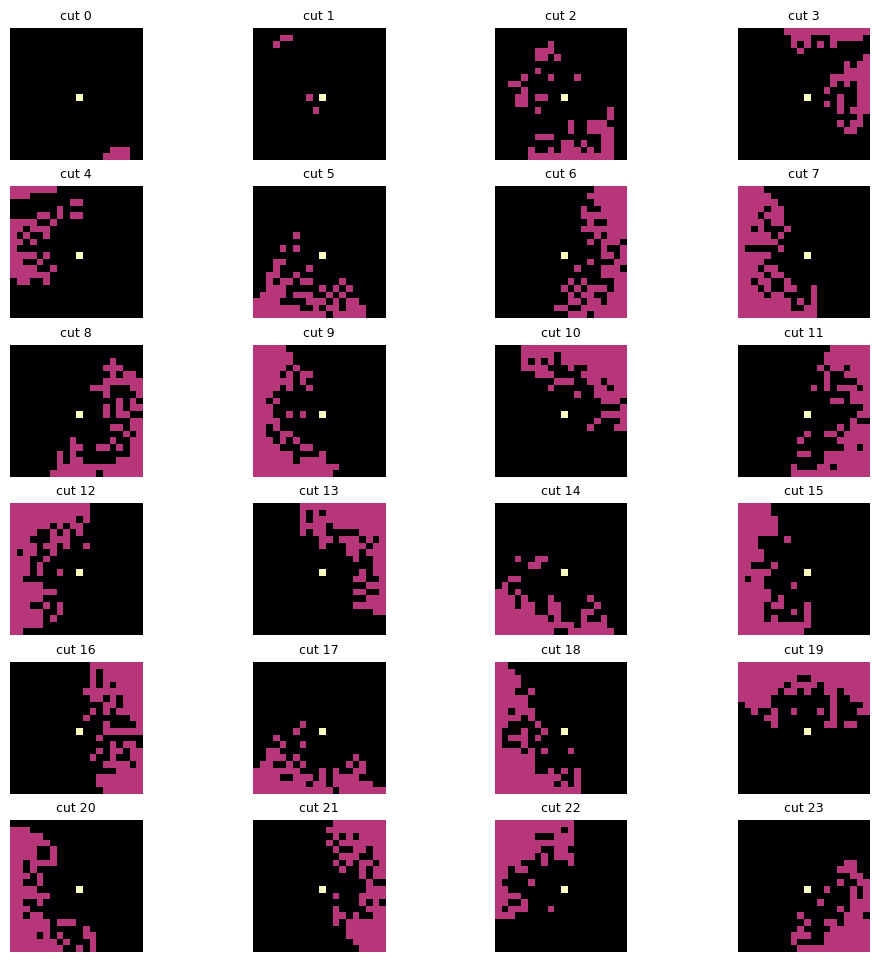

In [44]:
img, label = clicks_dataset[1]
cuts, clicks = cut_volume(label, cut_size=10, num=24)

plot_cuts(cuts)
plot_cuts(fake_errors(cuts))

In [21]:
from src.model import Unet
# from src.losses.dice import dice_coefficient

In [22]:
model = Unet(
    in_channels=2, 
    out_channels=1, 
    blocks=3
).to('cpu')

checkpoint = torch.load('../src/models/pretrained_dice_20.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [45]:
img, y = clicks_dataset[1]

model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to('cpu')
    y_pred = model(x)

In [46]:
y_pred.shape

torch.Size([1, 1, 40, 256, 256])

In [47]:
threshed_pred = torch.clone(y_pred)

In [73]:
threshed_pred[0,0][threshed_pred[0,0] < 0.6] = 0
threshed_pred[0,0][threshed_pred[0,0] >= 0.6] = 1

In [54]:
fig = px.imshow(threshed_pred[0,0,17])
fig.show()

Tumour indices:  8 34


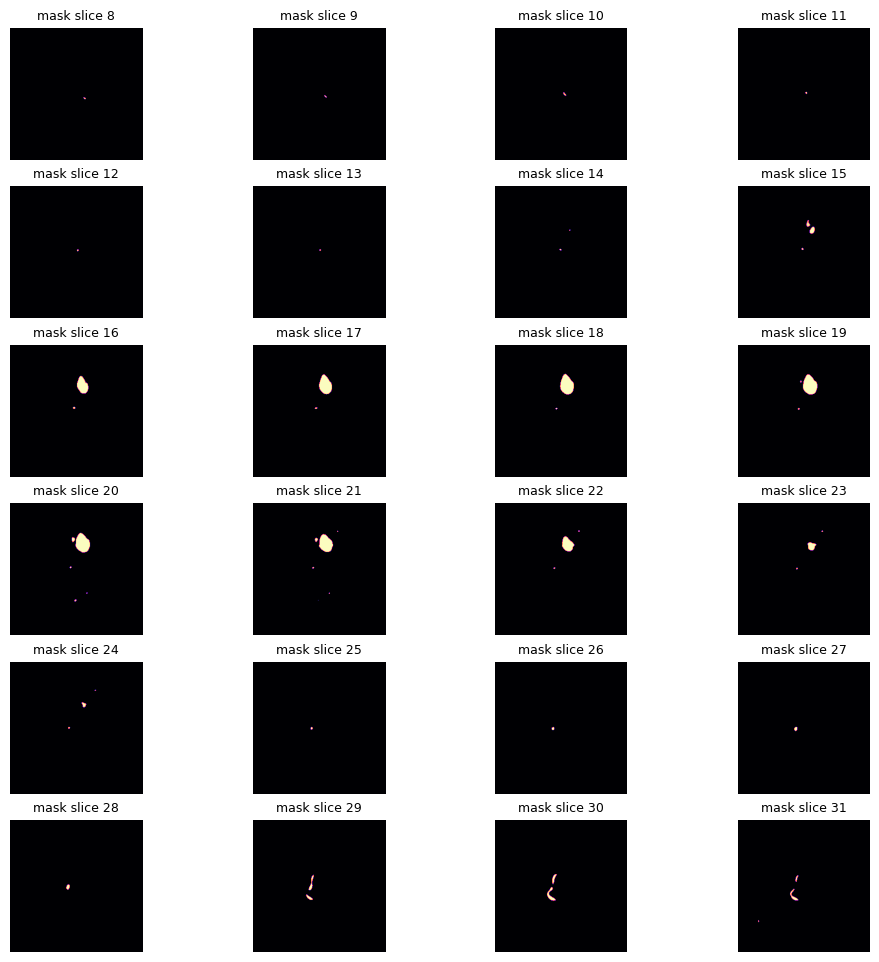

In [55]:
# y_pred[0][y_pred[0] > 0.9] = 1
plot_tumour(threshed_pred[0])

Tumour indices:  14 23


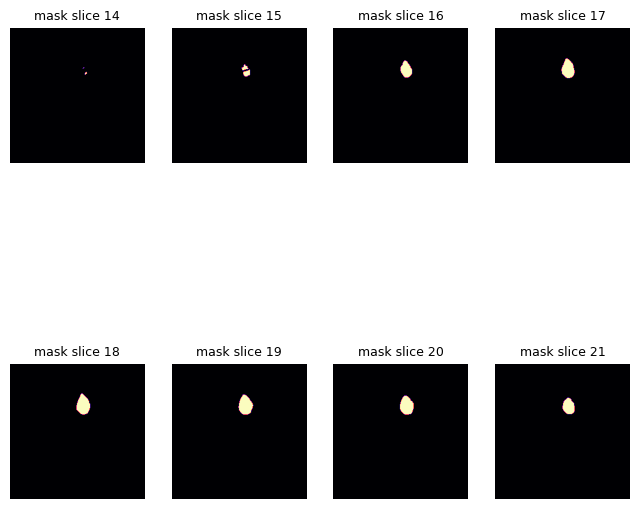

In [71]:
plot_tumour(y)

In [86]:
pred_cuts, _ = cut_volume(torch.stack((threshed_pred[0,0], label[1])), 20, 24)

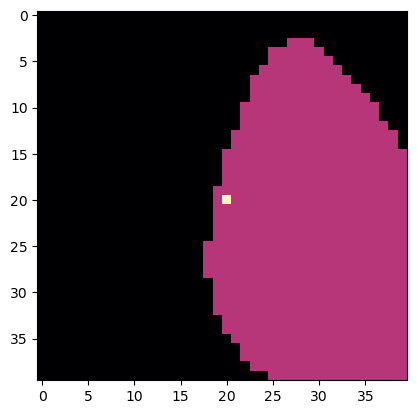

In [88]:
plt.imshow(pred_cuts[11], cmap="magma")

6


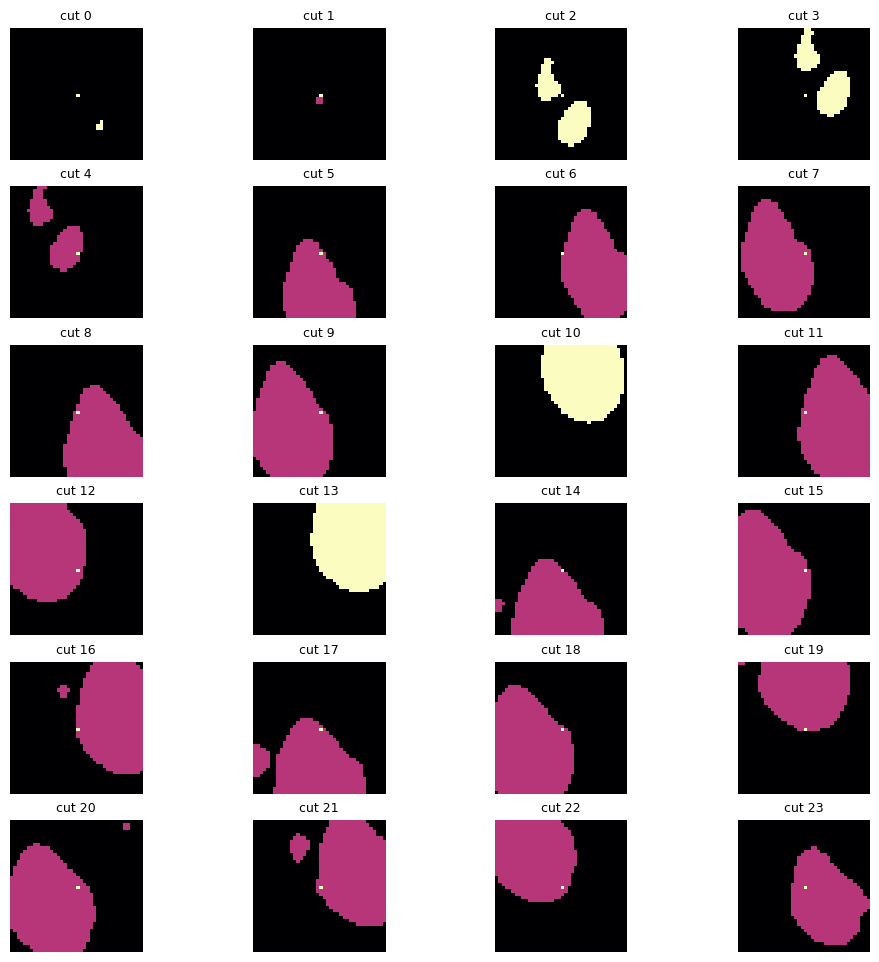

In [89]:
plot_cuts(pred_cuts)

6


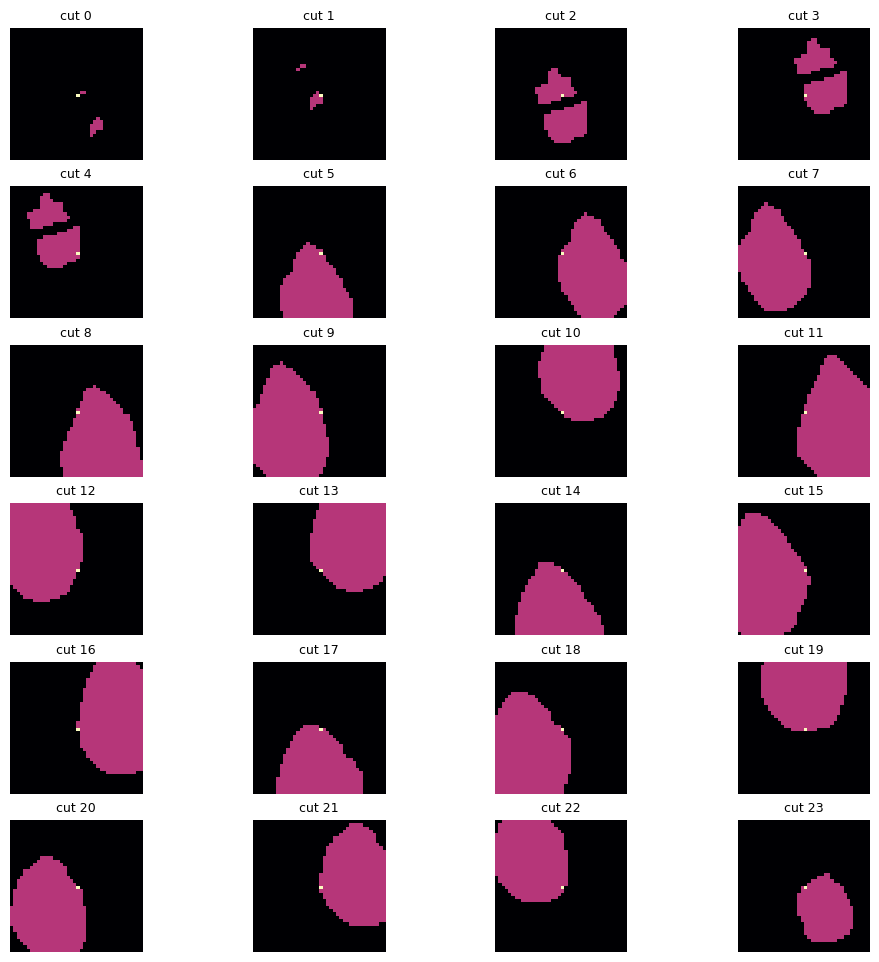

In [90]:
cc, _ = cut_volume(label, 20, 24)
plot_cuts(cc)